I want to see if I can use statsmodel ARIMA to model unemployment rates from FRED.

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
employ = pd.read_csv('UNRATE.csv')

In [3]:
employ.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [4]:
# Convert unemployment rate to a number, with coersion to throw NA's if conversion not possible
employ['date'] = pd.to_datetime(employ['DATE'], errors='coerce')

employ['datenum'] = pd.to_numeric(employ['date'], errors='coerce')

# Remove NA's
employ.dropna(inplace=True)

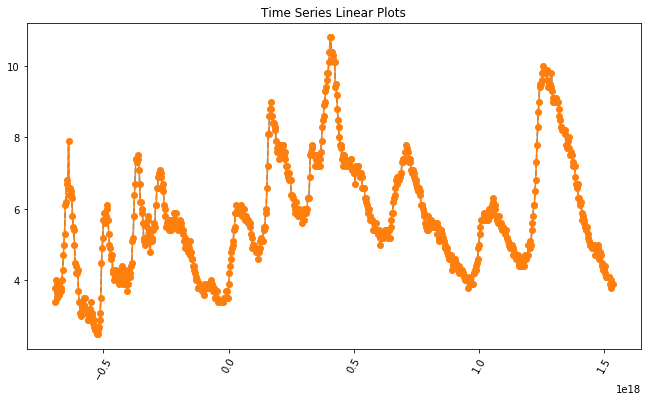

In [5]:
#Unrate is my unemployment rate so I'm looking at unemployment over time.
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)
plt.plot(employ.datenum, employ.UNRATE, '--')
plt.plot(employ.datenum, employ.UNRATE, 'o-')
plt.xticks(rotation=60)
plt.title('Time Series Linear Plots')
plt.show()

I'd like to look at a shorter period, say from Oct 2001 onward.

In [6]:
employcut = pd.DataFrame(employ[employ['datenum']>1*10**18])

In [7]:
employcut.head()

,DATE,UNRATE,date,datenum
645,2001-10-01,5.3,2001-10-01,1001894400000000000
646,2001-11-01,5.5,2001-11-01,1004572800000000000
647,2001-12-01,5.7,2001-12-01,1007164800000000000
648,2002-01-01,5.7,2002-01-01,1009843200000000000
649,2002-02-01,5.7,2002-02-01,1012521600000000000


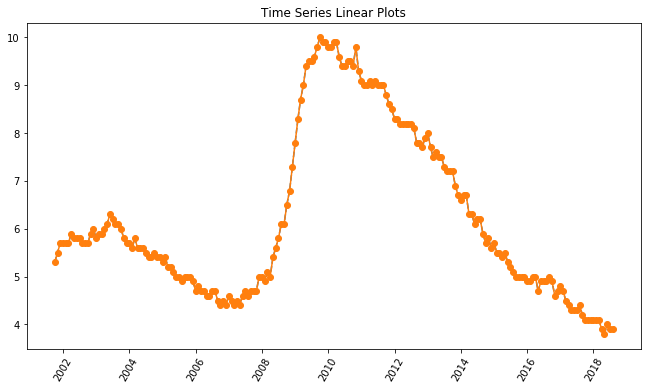

In [8]:
#Here I have unemployment rate over time from about 2002 onward. There is clearly an event here.
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)
plt.plot(employcut.date, employcut.UNRATE, '--')
plt.plot(employcut.date, employcut.UNRATE, 'o-')
plt.xticks(rotation=60)
plt.title('Time Series Linear Plots')
plt.show()

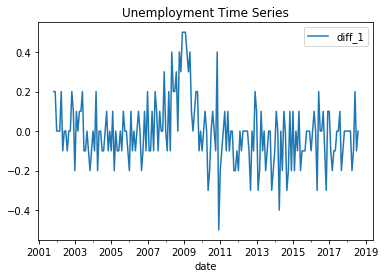

In [9]:
#Here I'm creating a stationary dataset for analysis.
employcut['diff_1'] = employcut.UNRATE - employcut.UNRATE.shift()
employcut.plot(y='diff_1', x= 'date')
plt.title('Unemployment Time Series')
plt.show()

In [10]:
employcut.index = employcut.date

In [11]:
employcut.head()

,DATE,UNRATE,date,datenum,diff_1
date,,,,,
2001-10-01,2001-10-01,5.3,2001-10-01,1001894400000000000,NaN
2001-11-01,2001-11-01,5.5,2001-11-01,1004572800000000000,0.2
2001-12-01,2001-12-01,5.7,2001-12-01,1007164800000000000,0.2
2002-01-01,2002-01-01,5.7,2002-01-01,1009843200000000000,0.0
2002-02-01,2002-02-01,5.7,2002-02-01,1012521600000000000,0.0


Text(0.5,1,'ACF')

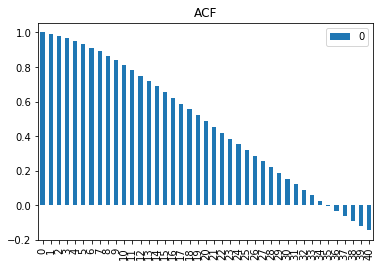

In [12]:
#Looking for autocorrelation using the acf tool.
from statsmodels.tsa.stattools import acf
acf_1 =  pd.DataFrame(acf(employcut.UNRATE))
acf_1.plot(kind='bar')
plt.title("ACF")

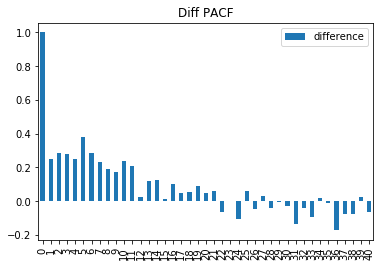

In [13]:
x_acf = pd.DataFrame(acf(employcut.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("Diff PACF")
plt.legend(['difference'])

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5,1,'PACF')

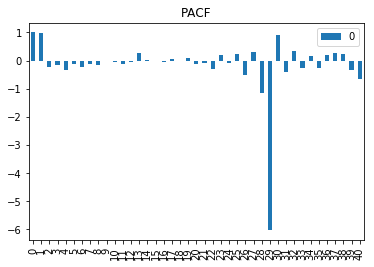

In [14]:
#Looking for autocorrelation using the pacf tool.
from statsmodels.tsa.stattools import pacf
x_pacf = pd.DataFrame(pacf(employcut.UNRATE))
x_pacf.plot(kind='bar')
plt.title("PACF")

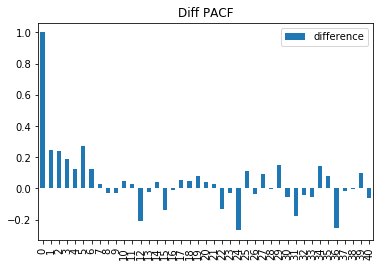

In [15]:
x_pacf = pd.DataFrame(pacf(employcut.diff_1[1:]))
x_pacf.plot(kind='bar')
plt.title("Diff PACF")
plt.legend(['difference'])

In the Diff PACF there is something going on from 1-5. I'll try different models and see what works best.

In [16]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(employcut.UNRATE, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                 UNRATE   No. Observations:                  203
Model:                     ARMA(1, 0)   Log Likelihood                  79.999
Method:                       css-mle   S.D. of innovations              0.161
Date:                Sun, 23 Sep 2018   AIC                           -153.997
Time:                        22:19:48   BIC                           -144.057
Sample:                    10-01-2001   HQIC                          -149.976
                         - 08-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1598      1.334      3.869      0.000       2.546       7.774
ar.L1.UNRATE     0.9949      0.005    218.961      0.000       0.986       1.004
                                    Roots   

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


This looks to be a strong model with significant coefficents and a log likelihood of 80. Let's look at the residuals.

Text(0.5,1,'Histogram of Residuals')

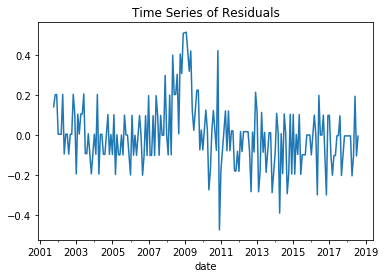

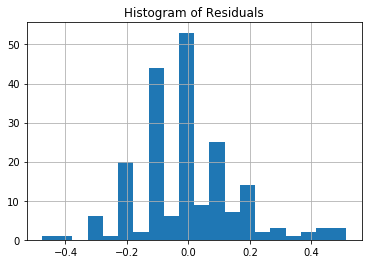

In [17]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

 The residuals are neither normal nor homoscedastic. I'll try a different model so I can better trust my results.

In [18]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(employcut.UNRATE, order=(2,0,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                 UNRATE   No. Observations:                  203
Model:                     ARMA(2, 1)   Log Likelihood                 103.481
Method:                       css-mle   S.D. of innovations              0.143
Date:                Sun, 23 Sep 2018   AIC                           -196.963
Time:                        22:19:49   BIC                           -180.397
Sample:                    10-01-2001   HQIC                          -190.261
                         - 08-01-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.9726      0.605      9.872      0.000       4.787       7.158
ar.L1.UNRATE     1.9596      0.024     82.778      0.000       1.913       2.006
ar.L2.UNRATE    -0.9623      0.024    -40.85

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'Histogram of Residuals')

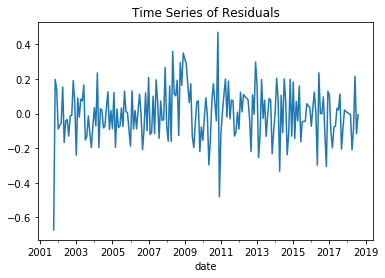

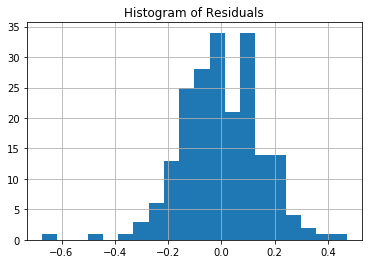

In [19]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

This model is only slightly weaker, with a log likelihood of 103 and significant coefficients, but the residuals look much better, and that's important.